In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd 
from pathlib import Path
from scipy.special import logit, expit
import matplotlib.pyplot as plt

In [2]:
import os
print(os.getcwd())
%cd ..

c:\Users\mtret\MyStudy\gp_lvm_ssvi\notebooks
c:\Users\mtret\MyStudy\gp_lvm_ssvi
c:\Users\mtret\MyStudy\gp_lvm_ssvi


# Notebook on running experiments with the PCR Dataset

This notebook is a cleaner version of the parts of the code you will need to test your own model on the PCR dataset and compare to the orignal baselines. For more background on the data and the problem set up see the paper: [Transfer learning Bayesian optimization for competitor DNA molecule design for use in diagnostic assays](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/epdf/10.1002/bit.28854).

## Loading Data

I've saved all the data you need in `data.csv`. In the original paper I use the rate `r` and the drift `m`. The drift is a bit weird and the penalty on it wasn't especially well thought out so I recommend you only focus on modelling the rate `r` which is the `Single Objective` results in the Bayesian optimisation bit. 

The column `PrimerPairReporter` describes which surface the data point is on and `BP` and `GC` are our input values (i.e. the x values). Each unique `PrimerPairReporter` should corrospond to a point on the latent space. 

### Cross Validation

For the cross validation, I ran it 201 times (it says 70 in the paper, but I must have done more runs since. If it is 70 I'm not sure if it's just the first 70 seeds or not. 201 because I didn't realise 0..200 would include both 0 and 200.) 

I figured the best way to give you the test train splits is as lists which you can find in the `train.txt` and `test.txt` files in the `data/cross_validation/seed_{seed}_pct_train_{pct_train}` files. 

To load the dataset for single run you can you this code:

In [3]:
work_dir = Path.cwd()
data = pd.read_csv(work_dir / 'data' / 'data.csv', index_col=[0])
data

,Experiment,Well,Reporter,Copies,lg10_Copies,Target,FPrimer,RPrimer,PrimerPair,BP,GC,Metric,Parameter,Value,EvaGreen,PrimerPairReporter,PrimerPairReporterBPGC
3552,JG034A,1,HEX,100000000.0,8.0,S044.12,FP004,RP004,FP004-RP004,88,0.431818,mean,r,0.810041,Probe,FP004-RP004-Probe,FP004-RP004-Probe-88-0.4318181818181818
3554,JG034A,2,HEX,100000000.0,8.0,S044.12,FP004,RP004,FP004-RP004,88,0.431818,mean,r,0.814632,Probe,FP004-RP004-Probe,FP004-RP004-Probe-88-0.4318181818181818
3556,JG034A,4,FAM,100000000.0,8.0,S044.13,FP004,RP004,FP004-RP004,88,0.431818,mean,r,0.841007,Probe,FP004-RP004-Probe,FP004-RP004-Probe-88-0.4318181818181818
3558,JG034A,5,FAM,100000000.0,8.0,S044.13,FP004,RP004,FP004-RP004,88,0.431818,mean,r,0.841116,Probe,FP004-RP004-Probe,FP004-RP004-Probe-88-0.4318181818181818
3560,JG034A,7,HEX,100000000.0,8.0,S044.2,FP004,RP004,FP004-RP004,30,0.466667,mean,r,0.952398,Probe,FP004-RP004-Probe,FP004-RP004-Probe-30-0.4666666666666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4726,JG067M,211,EVAGREEN,100000000.0,8.0,S067_b12a22_a_LVM_3,FP001,RP004,FP001-RP004,40,0.425000,mean,r,0.863390,EvaGreen,FP001-RP004-EvaGreen,FP001-RP004-EvaGreen-40-0.425
4728,JG067M,212,EVAGREEN,100000000.0,8.0,S067_b12a22_b_LVM_3,FP002,RP004,FP002-RP004,11,0.454545,mean,r,0.690643,EvaGreen,FP002-RP004-EvaGreen,FP002-RP004-EvaGreen-11-0.45454545454545453
4730,JG067M,213,FAM,100000000.0,8.0,S067_b12a22_c_LVM_3,FP004,RP004,FP004-RP004,309,0.359223,mean,r,0.699097,Probe,FP004-RP004-Probe,FP004-RP004-Probe-309-0.3592233009708738
4732,JG067M,214,HEX,100000000.0,8.0,S067_b12a22_d_LVM_3,FP004,FP005,FP004-FP005,476,0.348739,mean,r,0.574290,Probe,FP004-FP005-Probe,FP004-FP005-Probe-476-0.3487394957983193


In [4]:
# set the seed and the percentage of data in the training dataeset
seed = 0
pct_train = 50


# load the location codes for the train and test sets 
train_file = work_dir / f'data/cross_validation/seed_{seed}_pct_train_{pct_train}/train.txt'

with train_file.open('r') as f:
    train_locs = [line.rstrip('\n') for line in f]

test_file = work_dir / f'data/cross_validation/seed_{seed}_pct_train_{pct_train}/test.txt'

with test_file.open('r') as f:
    test_locs = [line.rstrip('\n') for line in f]


In [5]:
# filter the dataframe by the train and test locations to get the full train and test dataframes

train_df = data[data['PrimerPairReporterBPGC'].isin(train_locs)]
test_df = data[data['PrimerPairReporterBPGC'].isin(test_locs)]

train_df

,Experiment,Well,Reporter,Copies,lg10_Copies,Target,FPrimer,RPrimer,PrimerPair,BP,GC,Metric,Parameter,Value,EvaGreen,PrimerPairReporter,PrimerPairReporterBPGC
3552,JG034A,1,HEX,100000000.0,8.0,S044.12,FP004,RP004,FP004-RP004,88,0.431818,mean,r,0.810041,Probe,FP004-RP004-Probe,FP004-RP004-Probe-88-0.4318181818181818
3554,JG034A,2,HEX,100000000.0,8.0,S044.12,FP004,RP004,FP004-RP004,88,0.431818,mean,r,0.814632,Probe,FP004-RP004-Probe,FP004-RP004-Probe-88-0.4318181818181818
3556,JG034A,4,FAM,100000000.0,8.0,S044.13,FP004,RP004,FP004-RP004,88,0.431818,mean,r,0.841007,Probe,FP004-RP004-Probe,FP004-RP004-Probe-88-0.4318181818181818
3558,JG034A,5,FAM,100000000.0,8.0,S044.13,FP004,RP004,FP004-RP004,88,0.431818,mean,r,0.841116,Probe,FP004-RP004-Probe,FP004-RP004-Probe-88-0.4318181818181818
3564,JG034A,10,HEX,100000000.0,8.0,S044.4,FP004,RP004,FP004-RP004,40,0.450000,mean,r,0.920843,Probe,FP004-RP004-Probe,FP004-RP004-Probe-40-0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4722,JG067M,209,EVAGREEN,100000000.0,8.0,S067_8a718d_α_LVM_3,FP001,RP001x,FP001-RP001x,137,0.218978,mean,r,0.938214,EvaGreen,FP001-RP001x-EvaGreen,FP001-RP001x-EvaGreen-137-0.21897810218978103
4724,JG067M,210,EVAGREEN,100000000.0,8.0,S067_8a718d_β_LVM_3,FP002,RP002x,FP002-RP002x,38,0.421053,mean,r,0.841219,EvaGreen,FP002-RP002x-EvaGreen,FP002-RP002x-EvaGreen-38-0.42105263157894735
4726,JG067M,211,EVAGREEN,100000000.0,8.0,S067_b12a22_a_LVM_3,FP001,RP004,FP001-RP004,40,0.425000,mean,r,0.863390,EvaGreen,FP001-RP004-EvaGreen,FP001-RP004-EvaGreen-40-0.425
4728,JG067M,212,EVAGREEN,100000000.0,8.0,S067_b12a22_b_LVM_3,FP002,RP004,FP002-RP004,11,0.454545,mean,r,0.690643,EvaGreen,FP002-RP004-EvaGreen,FP002-RP004-EvaGreen-11-0.45454545454545453


### Bayesian Optimisation 

For the Bayesian optimisation I investigated two different scenarios:
- "Learning Many" where we learn many surfaces at the same time, adding one data point to each each iteration 
- and "One at a Time" where all surfaces are in the training set except one, which is learnt with one data point added each iteration

I also investigate two different methods of choosing the first points on a surface:
- "0 point start" where the first point on a new surface isn't specified so the model can choose (which the LVMOGP can do. For some of the baselines the first point was chosen randomly for this case)
- "centre" where the first point is selected as the most central point

Because we were working with real data, so can't evaluate new points on the surface, we select the next point out of a pool of data we have that the model hasn't seen yet (called the test set here).

To load the inital train set and test set you can use the following code:

In [20]:
train_df = data[data['PrimerPairReporterBPGC'].isin(train_locs)]
test_df = data[data['PrimerPairReporterBPGC'].isin(test_locs)]

surfs = ['FP004-RP004-Probe', 'FP001-RP001x-EvaGreen', 'FP002-RP002x-EvaGreen',
                'FP001-RP001x-Probe', 'FP005-FP001-Probe', 'RP001x-FP002-Probe',
                'RP002x-FP005-Probe', 'FP005-FP004-EvaGreen', 'RP002x-FP002-EvaGreen',
                'FP001-RP004-EvaGreen', 'FP002-RP004-EvaGreen', 'FP004-FP005-Probe',
                'RP008x-FP005-Probe', 'FP005-FP001-EvaGreen', 'RP002x-FP004-EvaGreen',
                'RP008x-FP001-EvaGreen']

test_names = [f'one_from_many_{surf}_r' for surf in surfs] + ['many_r']

for seed in range(0, 25):
    for start_point in ['0_point_start', 'centre']:
        for test_name in test_names:

            # load the location codes for the train and test sets 
            train_file = work_dir / f'data/bayes_opt/seed_{seed}_{test_name}_{start_point}/train.txt'

            try:

                with train_file.open('r') as f:
                    train_locs = [line.rstrip('\n') for line in f]
            except:
                print(f'seed {seed} {test_name} train missing')
                print(train_file)

            test_file = work_dir / f'data/bayes_opt/seed_{seed}_{test_name}_{start_point}/test.txt'

            try:

                with test_file.open('r') as f:
                    test_locs = [line.rstrip('\n') for line in f]
            except:
                print(f'seed {seed} {test_name} test missing')


seed 0 one_from_many_RP002x-FP004-EvaGreen_r train missing
/Users/res219/PCR_dataset_benchmark/data/bayes_opt/seed_0_one_from_many_RP002x-FP004-EvaGreen_r_0_point_start/train.txt
seed 0 one_from_many_RP002x-FP004-EvaGreen_r test missing
seed 0 one_from_many_RP008x-FP001-EvaGreen_r train missing
/Users/res219/PCR_dataset_benchmark/data/bayes_opt/seed_0_one_from_many_RP008x-FP001-EvaGreen_r_0_point_start/train.txt
seed 0 one_from_many_RP008x-FP001-EvaGreen_r test missing
seed 0 one_from_many_RP002x-FP004-EvaGreen_r train missing
/Users/res219/PCR_dataset_benchmark/data/bayes_opt/seed_0_one_from_many_RP002x-FP004-EvaGreen_r_centre/train.txt
seed 0 one_from_many_RP002x-FP004-EvaGreen_r test missing
seed 0 one_from_many_RP008x-FP001-EvaGreen_r train missing
/Users/res219/PCR_dataset_benchmark/data/bayes_opt/seed_0_one_from_many_RP008x-FP001-EvaGreen_r_centre/train.txt
seed 0 one_from_many_RP008x-FP001-EvaGreen_r test missing
seed 1 one_from_many_RP002x-FP004-EvaGreen_r train missing
/Users/

In [21]:
# filter the dataframe by the train and test locations to get the full train and test dataframes

train_df = data[data['PrimerPairReporterBPGC'].isin(train_locs)]
test_df = data[data['PrimerPairReporterBPGC'].isin(test_locs)]

train_df

,Experiment,Well,Reporter,Copies,lg10_Copies,Target,FPrimer,RPrimer,PrimerPair,BP,GC,Metric,Parameter,Value,EvaGreen,PrimerPairReporter,PrimerPairReporterBPGC
3560,JG034A,7,HEX,100000000.0,8.0,S044.2,FP004,RP004,FP004-RP004,30,0.466667,mean,r,0.952398,Probe,FP004-RP004-Probe,FP004-RP004-Probe-30-0.4666666666666667
3562,JG034A,8,HEX,100000000.0,8.0,S044.2,FP004,RP004,FP004-RP004,30,0.466667,mean,r,0.952871,Probe,FP004-RP004-Probe,FP004-RP004-Probe-30-0.4666666666666667
3564,JG034A,10,HEX,100000000.0,8.0,S044.4,FP004,RP004,FP004-RP004,40,0.450000,mean,r,0.920843,Probe,FP004-RP004-Probe,FP004-RP004-Probe-40-0.45
3566,JG034A,11,HEX,100000000.0,8.0,S044.4,FP004,RP004,FP004-RP004,40,0.450000,mean,r,0.919641,Probe,FP004-RP004-Probe,FP004-RP004-Probe-40-0.45
3568,JG034A,13,HEX,100000000.0,8.0,S044.8,FP004,RP004,FP004-RP004,55,0.454545,mean,r,0.876091,Probe,FP004-RP004-Probe,FP004-RP004-Probe-55-0.45454545454545453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4726,JG067M,211,EVAGREEN,100000000.0,8.0,S067_b12a22_a_LVM_3,FP001,RP004,FP001-RP004,40,0.425000,mean,r,0.863390,EvaGreen,FP001-RP004-EvaGreen,FP001-RP004-EvaGreen-40-0.425
4728,JG067M,212,EVAGREEN,100000000.0,8.0,S067_b12a22_b_LVM_3,FP002,RP004,FP002-RP004,11,0.454545,mean,r,0.690643,EvaGreen,FP002-RP004-EvaGreen,FP002-RP004-EvaGreen-11-0.45454545454545453
4730,JG067M,213,FAM,100000000.0,8.0,S067_b12a22_c_LVM_3,FP004,RP004,FP004-RP004,309,0.359223,mean,r,0.699097,Probe,FP004-RP004-Probe,FP004-RP004-Probe-309-0.3592233009708738
4732,JG067M,214,HEX,100000000.0,8.0,S067_b12a22_d_LVM_3,FP004,FP005,FP004-FP005,476,0.348739,mean,r,0.574290,Probe,FP004-FP005-Probe,FP004-FP005-Probe-476-0.3487394957983193


## Target Values

Rather than maximise or minimise the rate, our aim was to get as close to a target value as possible. The target we were aiming for was different for each unique surface (indicated by the `PrimerPairReporter`). You can load the targets using the following code, the important column is the `Target Rate`. 

In [22]:
targets = pd.read_csv(work_dir/'data/JG067 sequence targets.csv', index_col=[0])
targets['PrimerPair'] = targets[['FPrimer', 'RPrimer']].agg('-'.join, axis=1)
targets['EvaGreen'] = ((targets['-Strand Label'] == "None") & (targets['+Strand Label'] == "None"))
targets.loc[targets['EvaGreen'] == True, 'EvaGreen'] = 'EvaGreen'
targets.loc[targets['EvaGreen'] == False, 'EvaGreen'] = 'Probe'
targets['PrimerPairReporter'] = targets[['PrimerPair', 'EvaGreen']].agg('-'.join, axis=1)
targets = targets.drop_duplicates(subset=['PrimerPairReporter'], keep='first')
targets

,Sequence Name,Target Rate,FPrimer,RPrimer,-Strand Label,+Strand Label,Min BP,CAN Name,CAN UUID,PrimerPair,EvaGreen,PrimerPairReporter
0,S067_8a718d_α,0.902,FP001,RP001x,None,None,10,Penalized XOR,8a718d80064949059a599ea046a959c8,FP001-RP001x,EvaGreen,FP001-RP001x-EvaGreen
1,S067_8a718d_β,0.902,FP002,RP002x,None,None,10,Penalized XOR,8a718d80064949059a599ea046a959c8,FP002-RP002x,EvaGreen,FP002-RP002x-EvaGreen
2,S067_8a718d_a,0.866,FP005,FP001,None,L0,40,Penalized XOR,8a718d80064949059a599ea046a959c8,FP005-FP001,Probe,FP005-FP001-Probe
3,S067_8a718d_b,0.951,RP001x,FP002,L1,L1,70,Penalized XOR,8a718d80064949059a599ea046a959c8,RP001x-FP002,Probe,RP001x-FP002-Probe
4,S067_8a718d_c,0.866,RP002x,FP005,L0,None,40,Penalized XOR,8a718d80064949059a599ea046a959c8,RP002x-FP005,Probe,RP002x-FP005-Probe
5,S067_8a718d_d,0.653,FP005,FP004,None,None,10,Penalized XOR,8a718d80064949059a599ea046a959c8,FP005-FP004,EvaGreen,FP005-FP004-EvaGreen
6,S067_8a718d_e,0.758,FP004,RP004,L1,None,40,Penalized XOR,8a718d80064949059a599ea046a959c8,FP004-RP004,Probe,FP004-RP004-Probe
8,S067_b12a22_β,0.952,RP002x,FP002,None,None,10,Penalized AND,b12a2207d5394580967106cb2dc107ce,RP002x-FP002,EvaGreen,RP002x-FP002-EvaGreen
9,S067_b12a22_a,1.050,FP001,RP004,None,None,10,Penalized AND,b12a2207d5394580967106cb2dc107ce,FP001-RP004,EvaGreen,FP001-RP004-EvaGreen
10,S067_b12a22_b,1.050,FP002,RP004,None,None,10,Penalized AND,b12a2207d5394580967106cb2dc107ce,FP002-RP004,EvaGreen,FP002-RP004-EvaGreen


## Standardising Data 

You'll need to standardise both the input and output data. You'll also need to standardise the target values. This is a simplified version of the code we used: 

In [23]:
# for BP and GC we use these default values to standardise
defaults = {
        'BP': {'mu': 4.48, 'sig': 0.75},
        'GC': {'mu': -0.282, 'sig': 1},
    }

# for rate we take the mean and standard deviation of the data to standardise 
r_stdz = {'mu': data['Value'].mean(),
        'sig': data['Value'].std()}

def skip(x):
    """Returns input unmodified"""
    return x

# we also transform the data
transforms = {
        'BP': [np.log, np.exp],
        'GC': [logit, expit],
        'r': [skip, skip]
    }


# so the standardisers should be as follows:

def stdz(param, transform, mu, sigma) -> float:
    """Transforms, mean-centers, and scales parameter

    Parameters
    ----------
    x: float
    name: str
        Name of parameter
    lg10_Copies: float, default 5.
        Corresponding log10 concentration; only necessary for τ
    pymc3: bool, optional
        Whether to use pymc3's transforms

    Returns
    -------
    float
    """

    x_ = transform[0](param)
    return (x_ - mu) / sigma


def unstdz(z, transform, mu, sigma) -> float:
    """Transforms, mean-centers, and scales parameter

    Parameters
    ----------
    x: float
    name: str
        Name of parameter
    lg10_Copies: float, default 5.
        Corresponding log10 concentration; only necessary for τ
    pymc3: bool, optional
        Whether to use pymc3's transforms

    Returns
    -------
    float
    """
   
    x_ = z * sigma + mu
    return transform[1](x_)


#standardize
data['r_stdz'] = stdz(data['Value'], transforms['r'], r_stdz['mu'], r_stdz['sig'])
data['BP_stdz'] = stdz(data['BP'], transforms['BP'], defaults['BP']['mu'], defaults['BP']['sig'])
data['GC_stdz'] = stdz(data['GC'], transforms['GC'], defaults['GC']['mu'], defaults['GC']['sig'])

# unstandardize
data['r_unstdz'] = unstdz(data['r_stdz'], transforms['r'], r_stdz['mu'], r_stdz['sig'])
data['BP_unstdz'] = unstdz(data['BP_stdz'], transforms['BP'], defaults['BP']['mu'], defaults['BP']['sig'])
data['GC_unstdz'] = unstdz(data['GC_stdz'], transforms['GC'], defaults['GC']['mu'], defaults['GC']['sig'])


# check that the unstandardized value matches the original 
assert((data['Value'] - data['r_unstdz'] <1e-10).all())
assert((data['BP'] - data['BP_unstdz'] <1e-10).all())
assert((data['GC'] - data['BP_unstdz'] <1e-10).all())



## Acquistion Function 

As we are trying to get as close to a target value for each surface as possible, the acquisition function I used a varient on expected improvement designed for vector minimisation, taken from https://github.com/akuhren/target_vector_estimation. The following class is the implementation I used:

In [24]:
import copy
import numpy as np
from scipy.stats import ncx2, norm


class ExpectedImprovement:
    """This expected improvement class creates an acquisition function based on the target vector optimisation, except
    the objective values are scaled by constants alpha. This means we can alter which objectives are most important. If
    alphas = [1]*len(params) then we recover the original target vector optimisation"""

    def __init__(self, alphas=None):

        """:param params: list of parameters. should be either or both of 'm' and 'r'
        :param alphas: list of floats. If None, then alphas = [1]*len(params)"""

        params = ['r']

        self.params = ['r']

        if alphas is None:
            self.alpha =  1 
        else:
            self.alpha = alphas

    def filter_ys(self, ys, targets, params):
        """filter ys so all drifts (m) below the target drift are equal to the target
        :param ys: candas parameter array of the data
        :param targets: candas parameter array of the targets
        :param params: list of parameters. should be either or both of 'm' and 'r'
        :return: candas parameter array of the data with the drifts (m) below the target drift equal to the target
        """
        ys = copy.deepcopy(ys)
        if 'm' in params:
            targ_m = targets['m'].values()
            ms = ys['m'].values()
            ms[ms < targ_m] = targ_m
            ys['m'] = ms

        return ys

    def Chi_EI(self, mu, sig2, target, best_yet, k=1):
        """Expected improvement function taken from https://github.com/akuhren/target_vector_estimation
        :param mu: array of means
        :param sig2: array of variances
        :param target: array of targets
        :param best_yet: float of the best value so far
        :param k: int of the number of objectives
        :return: array of the expected improvement"""

        gamma2 = sig2.mean(axis=1)

        nc = ((target - mu) ** 2).sum(axis=1) / gamma2

        h1_nx = ncx2.cdf((best_yet / gamma2), k, nc)
        h2_nx = ncx2.cdf((best_yet / gamma2), (k + 2), nc)
        h3_nx = ncx2.cdf((best_yet / gamma2), (k + 4), nc)

        t1 = best_yet * h1_nx
        t2 = gamma2 * (k * h2_nx + nc * h3_nx)

        return t1 - t2

    def BestYet(self, ys, target):
        """Function to calculate the closest distance from the target we have observed so far
        :param ys: a series containing the values in the train set
        :param target_parrays: a 2x1 array containing the desired values for the rate and drift parameters
        :return best: the smallest distance between an observation and the target, a float"""

        ys_ = np.array(self.alpha * ys)
        target = target['Target Rate']
        target = np.vstack([self.alpha * np.atleast_2d(target)]*len(ys_)).reshape(-1, )

        assert (ys_.shape[0] == target.shape[0])
        best = ((ys_ - target) ** 2).min()
        return best

    def EI(self, preds, target, best_yet, params):
        """Expected improvement using target vector optimisation
        :param preds: a candas uncertain parameter array containing the mean and variance of the predictions
        :param target_parrays: a 2x1 array containing the desired values for the rate and drift parameters
        :param best_yet: the smallest distance between an observation and the target, a float
        :param params: list of parameters. should be either or both of 'm' and 'r'
        :return ei: the expected improvements of each prediction"""

        mu = np.array([self.alpha * preds[f'mu'].ravel()]).T
        sig2 = np.array([self.alpha ** 2 * preds[f'sig2'].ravel()]).T
        target = np.hstack([self.alpha * np.atleast_2d(target['Target Rate'])])

        k = len(params)
        ei = self.Chi_EI(mu, sig2, target, best_yet, k=k)

        return ei

    def get_error_from_optimization_target(self, df):
        """Get the error of the points so far from the optimization target.
        :param df: a pandas dataframe containing the predictions and the optimization target
        :return df: the same dataframe with an extra column containing the error from the optimization target"""
        df[f'error from optimization target z'] = np.sqrt(np.sum([(alpha * df[f'target {param} z']
                                                                   - alpha * df[f'stzd {param}']) ** 2 for param, alpha
                                                                  in
                                                                  self.alphas.items()], axis=0))
        return df



Given a test dataframe that you want to select the next points out of, and a set of predictions, you can calculate the expected improvement and get the next point as follows:

In [25]:
params = ['r'] # rate only 

# expected improvement object
ei = ExpectedImprovement()

pprs = targets['PrimerPairReporter'].to_list() # the surfaces to be optimised 

ppr  = pprs[0] # for sake of demonstration, we'll just take the first one 

# calculate the best distance from target so far
ys = {}
ys_parray = {}


pred_df = pd.DataFrame()

pred_df['PrimerPairReporter'] = test_df['PrimerPairReporter']
pred_df['mu'] = np.random.uniform(0, 1, (len(test_df), 1))
pred_df['sig2'] = np.random.uniform(0, 1, (len(test_df), 1))

ys = train_df[train_df['PrimerPairReporter'] == ppr]
ys = ys.groupby(['BP', 'GC', 'PrimerPairReporter']).mean().reset_index()['Value']

if len(ys) == 0: # if no points have been observed on a surface yet, set best_yet to 4 
    best_yet = np.ones(len(pred_df[pred_df['PrimerPairReporter'] == ppr]), ) * 4
else:
    best_yet = ei.BestYet(ys, targets[targets['PrimerPairReporter'] == ppr])


preds = pred_df[pred_df['PrimerPairReporter'] == ppr]


# calculate the expected improvement
exp_improv = ei.EI(preds, targets[targets['PrimerPairReporter'] == ppr], best_yet, ['r'])
exp_improv[np.isnan(exp_improv )] = 0

In [26]:
pred_df = pred_df[pred_df['PrimerPairReporter'] == ppr].sample(frac=1) # randomise the order, incase 2 have the same EI value, it will select the first
pred_df['exp_improv'] = exp_improv
arg_max = np.argmax(pred_df['exp_improv'])
next_point = pd.DataFrame(pred_df.iloc[arg_max]).T

print('next point:')
next_point

next point:


,PrimerPairReporter,mu,sig2,exp_improv
3970,FP001-RP001x-EvaGreen,0.422325,0.682728,0.000003


## Metrics

For cross validation, we use root mean squared error (RMSE) and negative log predictive density (NLPD). For Bayesian optimisation, we used cumulative regret, although it would be better to just use regret. 


In [27]:
def get_nlpd(mu, sig2, y_true):
    """ calculate the negative log predictive density
    :param mu: mean of the predictions
    :param sig2: variance of the predictions
    :param y_true: true values
    :return nlpd: negative log predictive density"""
    nlpd = - (-0.5 * np.log(2 * np.pi) - 0.5 * np.log(sig2)
                - 0.5 * (np.square(y_true.ravel().reshape(len(y_true.ravel()), ) - mu)) / sig2)

    return nlpd

def get_squared_error(mu, y_true):
    """calcualte the squared error
    :param mu: mean of the predictions
    :param y_true: true values"""
    rmse = np.square(mu- y_true)
    return rmse

def get_regret(y, y_best_dist, target):
    """calcualate regret. Because we are trying to get as close to the target we first calculate the distance from the target. 
    :param y: y values
    :param y_best: the best (closest) y value so far
    :param target: the target for the current surface"""

    y_dist = np.abs(y - target)
    regret = y_dist - y_best_dist

    return regret


Now we can calculate the metrics:

In [28]:
ys = test_df[test_df['PrimerPairReporter'] == ppr]['Value']

pred_df = pd.DataFrame()
pred_df['PrimerPairReporter'] = test_df['PrimerPairReporter']
pred_df['mu'] = np.random.uniform(0, 1, (len(test_df), 1))
pred_df['sig2'] = np.random.uniform(0, 1, (len(test_df), 1))

nlpd = get_nlpd(pred_df[pred_df['PrimerPairReporter'] == ppr]['mu'].to_numpy(), 
                pred_df[pred_df['PrimerPairReporter'] == ppr]['sig2'].to_numpy(), ys)

squared_error = get_squared_error(pred_df[pred_df['PrimerPairReporter'] == ppr]['mu'].to_numpy(), ys)


target = targets[targets['PrimerPairReporter'] == ppr]['Target Rate']

regret = get_regret(y=ys.to_numpy(), y_best_dist=ei.BestYet(ys, targets[targets['PrimerPairReporter'] == ppr])
, target=target.to_numpy())


print(f'NLPD: {np.mean(nlpd)}, RMSE: {np.sqrt(np.mean(squared_error))}, regret: {np.min(regret)}')


NLPD: 1.3093671146542396, RMSE: 0.42633375026065673, regret: 0.02827830398522245


## Baseline Results

Luckily, I saved the results for the latent variable multioutput GP (LVMOGP), the linear model of coregionalisation (LMC), the multi-ouput Gaussian process (MOGP) and the average Gaussian process (AvgGP). These can be found in the results csvs in the `results` directory. You can load these using the following code.

If it is easy, I suggest you create your own version of the LVMOGP both with and without the new VI stuff. This shouldn't be difficult as it would just mean adapting your code slightly and would seperate out whether any improvement is actually due to the new VI method or just due to better implementation / initialisation. 

In [29]:
baseline_results = pd.read_csv(work_dir / 'results' / 'cross_validation.csv', index_col=0)

print(baseline_results.columns)

Index(['no test points', 'no train points', 'mo_indi_test_RMSE',
       'mo_indi_test_NLPD', 'mo_indi_test_RMSE_z', 'mo_indi_test_NLPD_z',
       'lmc_test_RMSE', 'lmc_test_NLPD', 'lmc_test_RMSE_z', 'lmc_test_NLPD_z',
       'avg_test_RMSE', 'avg_test_NLPD', 'avg_test_RMSE_z', 'avg_test_NLPD_z',
       'lvm_test_RMSE', 'lvm_test_NLPD', 'lvm_test_RMSE_z', 'lvm_test_NLPD_z',
       'mo_indi_train_RMSE', 'mo_indi_train_NLPD', 'mo_indi_train_RMSE_z',
       'mo_indi_train_NLPD_z', 'lmc_train_RMSE', 'lmc_train_NLPD',
       'lmc_train_RMSE_z', 'lmc_train_NLPD_z', 'avg_train_RMSE',
       'avg_train_NLPD', 'avg_train_RMSE_z', 'avg_train_NLPD_z',
       'lvm_train_RMSE', 'lvm_train_NLPD', 'lvm_train_RMSE_z',
       'lvm_train_NLPD_z', 'seed', 'n_train', 'pct_train', 'param'],
      dtype='object')


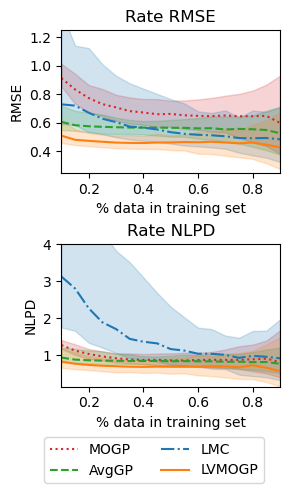

In [30]:
# plot the cross validation results

def plot_Xvalid_subplot(all_results_df, param, metric, ax, traintest, legend=False):
    linestyles = {'lmc': 'dashdot', 'mo_indi': 'dotted', 'lvm': 'solid', 'avg': 'dashed'}

    df = all_results_df[all_results_df['param'] == param]
    test2 = df.groupby(['pct_train']).median().drop(columns=['no test points', 'no train points'])
    test3 = df.groupby(['pct_train']).quantile(q=0.05).drop(columns=['no test points', 'no train points'])
    test4 = df.groupby(['pct_train']).quantile(q=0.95).drop(columns=['no test points', 'no train points'])

    model_names = ['mo_indi', 'avg', 'lmc', 'lvm']
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = {'lmc': cols[0], 'mo_indi': cols[3], 'lvm': cols[1], 'avg': cols[2]}
    for tt in [traintest]:
        for mod_name in model_names:
            test2.plot(y=[f'{mod_name}_{tt}_{metric}'], ax=ax,
                       color=colors[mod_name], legend=False,
                       linestyle=linestyles[mod_name])

        for mod_name in model_names:

            col = f'{mod_name}_{tt}_{metric}'
            ax.fill_between(test2.index, test3[col].to_numpy(), test4[col].to_numpy(), alpha=0.2,
                            color=colors[mod_name])

        # if (metric == 'RMSE') & (tt == 'test') & (param=='m'):
        #     ax.ylim(0, 0.02)
        ax.set_title(f'{param}')
        if legend:
            ax.legend()
        ax.set_xlabel('% data in training set')
        ax.set_ylabel(metric[:4])

all_results_df = baseline_results[(baseline_results.index == 'all') & (baseline_results['seed'] <200)]

fig, axs = plt.subplots(nrows=2, ncols=len(params), figsize=[3, 4.5])
axs = axs.flatten()
i = 0
param_names = ['Rate', 'Drift', 'Rate', 'Drift']
for metric in ['RMSE_z', 'NLPD_z']:
    for param in params:
        plot_Xvalid_subplot(all_results_df, 'r', metric, ax=axs[i], traintest='test', legend=False)
        axs[i].set_xlim(all_results_df['pct_train'].min(),all_results_df['pct_train'].max())
        axs[i].set_title('')
        # axs[i].set_xlabel('')
        i+=1

axs[0].set_title(f'{param_names[0]} RMSE')
axs[1].set_title(f'{param_names[0]} NLPD')
axs[0].set_ylim(0.25, 1.25)
# axs[1].set_ylim(0.3, 1.5)
axs[1].set_ylim(0.15, 4)
# axs[3].set_ylim(0.3, 5)

fig.legend(labels=['MOGP', 'AvgGP', 'LMC', 'LVMOGP'], loc="lower center", ncols=2,
            bbox_to_anchor=(0.53, -0.1))
# fig.supxlabel(f'% data in training set')
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
# plt.subplots_adjust(hspace=0.4, wspace=0.4)


And the same for the Bayes opt. The plotting for the Bayes opt from my code is pretty messy so I suggest you plot it yourself, although it shouldn't be hard. 

In [31]:
# and for the Bayes opt
baseline_results = pd.read_csv(work_dir / 'results' / 'bayes_opt_0_point_start_learning_many.csv', index_col=[0])

print(baseline_results.columns)



Index(['BP', 'GC', 'PrimerPairReporter', 'r', 'stzd r', 'r_mu', 'r_sig2',
       'r_mu_z', 'r_sig2_z', 'm', 'stzd m', 'm_mu', 'm_sig2', 'm_mu_z',
       'm_sig2_z', 'EI_z', 'Sequence Name', 'target r', 'target r z',
       'target m', 'target m z', 'model', 'iteration', 'error r',
       'error from target r z', 'error from target r', 'error r z', 'error m',
       'error from target m z', 'error from target m', 'error m z',
       'initial_surface', 'seed'],
      dtype='object')
